In [1]:
import backtrader as bt
import datetime
import yfinance as yf
%matplotlib inline

#Get EOD date from Yahoo Finance
symbols = ['AAPL', 'MSFT', 'KO']

df_list = [yf.download(s, start='2012-01-01') for s in symbols]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
class maCross(bt.Strategy):
    '''
    For an official backtrader blog on this topic please take a look at:

    https://www.backtrader.com/blog/posts/2017-04-09-multi-example/multi-example.html

    oneplot = Force all datas to plot on the same master.
    '''
    params = (
    ('sma1', 40),
    ('sma2', 200),
    ('oneplot', True)
    )

    def __init__(self):
        '''
        Create an dictionary of indicators so that we can dynamically add the
        indicators to the strategy using a loop. This mean the strategy will
        work with any numner of data feeds. 
        '''
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[d] = dict()
            self.inds[d]['sma1'] = bt.indicators.SimpleMovingAverage(
                d.close, period=self.params.sma1)
            self.inds[d]['sma2'] = bt.indicators.SimpleMovingAverage(
                d.close, period=self.params.sma2)
            self.inds[d]['cross'] = bt.indicators.CrossOver(self.inds[d]['sma1'],self.inds[d]['sma2'])

            if i > 0: #Check we are not on the first loop of data feed:
                if self.p.oneplot == True:
                    d.plotinfo.plotmaster = self.datas[0]

    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size
            if not pos:  # no market / no orders
                if self.inds[d]['cross'][0] == 1:
                    self.buy(data=d, size=1000)
                elif self.inds[d]['cross'][0] == -1:
                    self.sell(data=d, size=1000)
            else:
                if self.inds[d]['cross'][0] == 1:
                    self.close(data=d)
                    self.buy(data=d, size=1000)
                elif self.inds[d]['cross'][0] == -1:
                    self.close(data=d)
                    self.sell(data=d, size=1000)

    def notify_trade(self, trade):
        dt = self.data.datetime.date()
        if trade.isclosed:
            print('{} {} Closed: PnL Gross {}, Net {}'.format(
                                                dt,
                                                trade.data._name,
                                                round(trade.pnl,2),
                                                round(trade.pnlcomm,2)))



2013-03-13 KO Closed: PnL Gross -1760.0, Net -1835.88
2013-09-06 AAPL Closed: PnL Gross 3155.36, Net 3116.6
2014-01-06 KO Closed: PnL Gross -1890.0, Net -1969.07
2014-05-05 KO Closed: PnL Gross -930.0, Net -1010.37
2015-05-29 MSFT Closed: PnL Gross -3440.0, Net -3531.42
2015-10-23 MSFT Closed: PnL Gross -8010.0, Net -8106.59
2016-06-16 MSFT Closed: PnL Gross -2780.0, Net -2881.82
2016-08-08 MSFT Closed: PnL Gross -8540.0, Net -8647.58
2016-08-26 AAPL Closed: PnL Gross -3135.0, Net -3185.57
2019-03-04 MSFT Closed: PnL Gross -8399.99, Net -8617.63
2022-03-09 MSFT Closed: PnL Gross 170420.01, Net 170023.55
2022-05-26 AAPL Closed: PnL Gross -96027.5, Net -96206.25


<IPython.core.display.Javascript object>


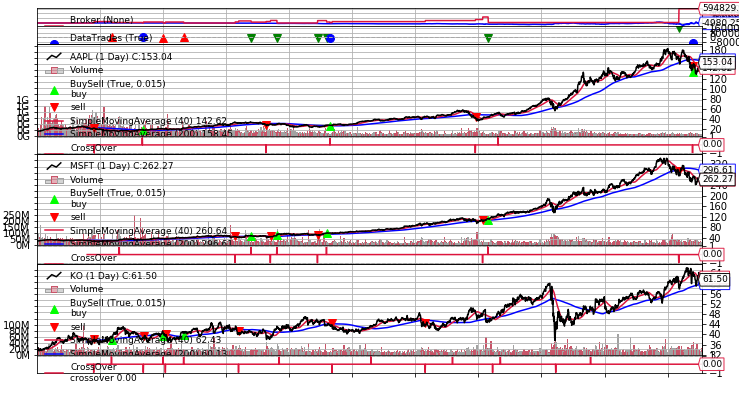

[[<Figure size 432x288 with 11 Axes>]]

In [3]:
#Initialize cerebro engine
cerebro = bt.Cerebro()

#Add data feed to cerebro
for i, df in enumerate(df_list):
    feed = bt.feeds.PandasData(dataname=df, name=symbols[i])
    cerebro.adddata(feed)
    
    
#Add our strategy
cerebro.addstrategy(maCross, oneplot=False) 
 
#Set our desired cash start
cerebro.broker.setcash(10000.0)

# Set the commission
cerebro.broker.setcommission(commission=0.001)

#add sizer 50% of the whole portoflio
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

#add annual return analyzer
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')

#Kick off the run
strategy_res = cerebro.run()

#Plot out the back testing results
cerebro.plot()

